#Librerie e Dati

## Import librerie

In [0]:
!pip install -q keras==2.3.0
import keras
import tqdm
import skimage
from keras.preprocessing import image as kimage
from keras.applications import vgg16
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten
from keras.models import Model
from keras import callbacks
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import zipfile

## Import dati

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%%capture
zipped = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/Assignment 4/sign-language-digits-dataset.zip", "r")
zipped.extractall()
zipped.close

In [0]:
features = np.load("/content/Sign-language-digits-dataset/X.npy")
labels = np.load("/content/Sign-language-digits-dataset/Y.npy")

Si effettua una modifica dei valori della variabile dipendente labels, da una versione one-hot encoding si passa alla cifra intera tramite la funzione argmax.

## Modifica del label

In [0]:
labels.shape

(2062, 10)

In [0]:
labels = np.argmax(labels, axis=1)

In [0]:
labels.shape

(2062,)

0


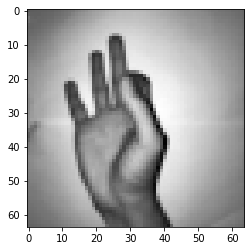

In [0]:
plt.imshow(features[0], cmap="gray")
print(labels[0])

Si può notare che il valore che viene evidenziato nella label è diverso da quello rappresentato nell'immagine. Per questo motivo si procede a modificare il label con il numero rappresentato correttamente secondo la codifica del linguaggio dei segni

In [0]:
labels2 = np.zeros(len(labels))
labels2[labels == 0] = int(9)
labels2[labels == 1] = int(0)
labels2[labels == 2] = int(7)
labels2[labels == 3] = int(6)
labels2[labels == 4] = int(1)
labels2[labels == 5] = int(8)
labels2[labels == 6] = int(4)
labels2[labels == 7] = int(3)
labels2[labels == 8] = int(2)
labels2[labels == 9] = int(5)
labels = labels2

9.0


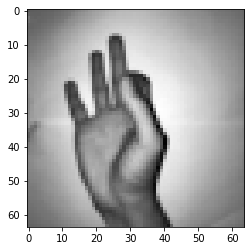

In [0]:
plt.imshow(features[0], cmap="gray")
print(labels[0])

Ora il risultato è corretto, il 9 viene rappresentato congiungendo pollice e indice della stessa mano.

## Modifica delle immagini
Si procede a modificare le immagini da scala di grigi a immagini in RGB, come richiesto dalla rete VGG16 (*che verrà caricata in seguito all'operazione*)


In [0]:
features.shape

(2062, 64, 64)

## Overview del Dataset

In [0]:
valori = pd.DataFrame(labels, columns = ["target"])
valori.head(3)

,target
0,9.0
1,9.0
2,9.0


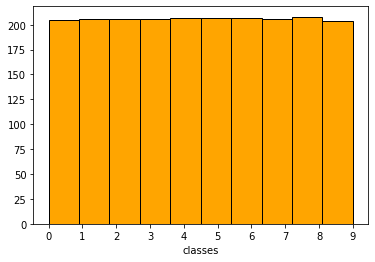

In [0]:
plt.hist(valori["target"], edgecolor='black', color = ["orange"], )
plt.xticks(np.arange(10))
plt.xlabel("classes")
plt.show()

Le immagini in scala di grigi possiedono solo un canale, si modificano per arrivare a 3 nella codifica RGB

In [0]:
import cv2 as cv

rgb_features = []
for x in range(0, len(features)):
  rgb_features.append(cv2.cvtColor(features[x], cv2.COLOR_GRAY2RGB))
features = np.array(rgb_features)
features = features/255

In [0]:
features.shape

(2062, 64, 64, 3)

# Import modello VGG16 e relativa preprocessing function

In [0]:
base_net = vgg16.VGG16(input_shape=(64,64,3), include_top=False, weights = "imagenet", pooling="avg")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58892288/58889256 [==============================] - 5s 0us/step


Si impone che la rete non possa effettuare training di parametri, ma che la conoscenza venga trasferita attraverso l'adozione dei pesi della rete provenienti da "imagenet" per applicarla al caso considerato, effettuando quindi Transfer Learning

In [0]:
for layer in base_net.layers:
  layer.trainable = False

Si osserva la struttura della rete per determinare in che punto effettuare il taglio dei layer, per permettere una buona rappresentazione delle immagini da fornire ad un classificatore esterno

In [0]:
base_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

L'approccio che verrà implementato è quello di effettuare il taglio alla fine di ogni "block" (insieme di più layer dello stesso tipo)

#Train e Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, stratify = labels, test_size=0.2, random_state=1996)

# Prima modifica della rete neurale:


*   Si effettua un taglio della rete fino al blocco "block4_pool"



In [0]:
x = base_net.get_layer("block4_pool").output
x = Flatten()(x)
net = Model(inputs = base_net.input, outputs = x)

In [0]:
base_net.get_layer("block4_pool").output_shape

(None, 4, 4, 512)

In [0]:
net.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

Si effettua preprocessing dei dati passandoli alla rete neurale VGG16, in questo modo è possibile ottenere una rappresentazione dell'immagine codificata attraverso i layer pre-trainati

Train:

In [0]:
features_codifica = net.predict(X_train, verbose = 1)


1649/1649 [==============================] - 6s 3ms/step


Test:

In [0]:
features_codifica_test = net.predict(X_test, verbose = 1)

413/413 [==============================] - 1s 2ms/step


##Classificatore SVM (prima codifica)

Si sceglie come classificatore il modello SVM, permette di classificare l'immagine fornendogli in input una rappresentazione codificata dell'immagine (generata dalla rete neurale base_net)

Si procede a valutare la dimensione della codifica che verrà passata al classificatore SVM

In [0]:
len(features_codifica[0])

8192

Si forniscono in input i parametri al classificatore attraverso una parameters grid, si vuole utilizzare la versione Radial Basis Function "rbf".
<br> Si decide di determinare i migliori parametri per il classificatore tramite la funzione GridSearchCV.

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [0]:
griglia_params = {"C" : [50, 100, 500, 1000, 1500], "gamma" : [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1]}
classificatore = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), griglia_params, cv = 2)

In [0]:
#Train the model using the training sets
classificatore = classificatore.fit(features_codifica, y_train)

#Migliori parametri
print("i parametri ideali per il classificatore SVM sono:" + " C: "  + str(classificatore.best_estimator_.C) + " gamma:" + str(classificatore.best_estimator_.gamma))

i parametri ideali per il classificatore SVM sono: C: 50 gamma:0.5


Si effettua una classificazione sui valori del Test set (features_codifica_test)

In [0]:
#Predict the response for test dataset
predetti = classificatore.predict(features_codifica_test)

I valori predetti sono utilizzati con quelli reali per valutare la performance del classificatore

In [0]:
print(classification_report(y_test, predetti))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        41
         1.0       0.98      1.00      0.99        41
         2.0       0.95      0.95      0.95        41
         3.0       1.00      0.98      0.99        41
         4.0       0.82      0.90      0.86        41
         5.0       1.00      1.00      1.00        42
         6.0       0.88      0.90      0.89        42
         7.0       0.94      0.80      0.87        41
         8.0       0.88      0.88      0.88        42
         9.0       0.91      0.95      0.93        41

    accuracy                           0.93       413
   macro avg       0.94      0.93      0.93       413
weighted avg       0.94      0.93      0.93       413



# Seconda modifica della rete neurale:


*   Si effettua un taglio della rete fino al blocco "block3_pool"



In [0]:
x = base_net.get_layer("block3_pool").output
x = Flatten()(x)
net2 = Model(inputs = base_net.input, outputs = x)

In [0]:
net2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [0]:
features_codifica2 = net2.predict(X_train, verbose = 1)

1649/1649 [==============================] - 1s 810us/step


In [0]:
features_codifica2_test = net2.predict(X_test, verbose = 1)

413/413 [==============================] - 0s 755us/step


##Classificatore SVM (seconda codifica)

Si procede a valutare la dimensione della seconda codifica che verrà passata al classificatore SVM

In [0]:
len(features_codifica2[0])

16384


Si forniscono in input i parametri al classificatore attraverso una parameters grid.

In [0]:
griglia_params = {"C" : [50, 100, 500, 1000, 1500], "gamma" : [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1]}
classificatore = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), griglia_params, cv = 2)

In [0]:
#Train the model using the training sets
classificatore = classificatore.fit(features_codifica2, y_train)

#Migliori parametri
print("i parametri ideali per il classificatore SVM sono:" + " C: "  + str(classificatore.best_estimator_.C) + " gamma:" + str(classificatore.best_estimator_.gamma))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


i parametri ideali per il classificatore SVM sono: C: 50 gamma:0.01


Si effettua una classificazione sui valori del Test set (features_codifica_test)

In [0]:
#Predict the response for test dataset
predetti2 = classificatore.predict(features_codifica2_test)

I valori predetti sono utilizzati con quelli reali per valutare la performance del classificatore

In [0]:
print(classification_report(y_test, predetti2))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        41
         1.0       0.98      1.00      0.99        41
         2.0       0.97      0.93      0.95        41
         3.0       1.00      0.98      0.99        41
         4.0       0.89      0.98      0.93        41
         5.0       1.00      1.00      1.00        42
         6.0       0.95      0.98      0.96        42
         7.0       0.87      0.83      0.85        41
         8.0       0.90      0.90      0.90        42
         9.0       1.00      1.00      1.00        41

    accuracy                           0.96       413
   macro avg       0.96      0.96      0.96       413
weighted avg       0.96      0.96      0.96       413



# Terza modifica della rete neurale:


*   Si effettua un taglio della rete fino al blocco "block2_pool"



In [0]:
x = base_net.get_layer("block2_pool").output
x = Flatten()(x)
net3 = Model(inputs = base_net.input, outputs = x)

In [0]:
net3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0   

In [0]:
features_codifica3 = net3.predict(X_train, verbose = 1)

1649/1649 [==============================] - 1s 706us/step


In [0]:
features_codifica3_test = net3.predict(X_test, verbose = 1)

413/413 [==============================] - 0s 615us/step


##Classificatore SVM (seconda codifica)

Si procede a valutare la dimensione della terza codifica che verrà passata al classificatore SVM

In [0]:
len(features_codifica3[0])

32768


Si forniscono in input i parametri al classificatore attraverso una parameters grid.

In [0]:
griglia_params = {"C" : [50, 100, 500, 1000, 1500], "gamma" : [0.005, 0.01, 0.02, 0.05, 0.1, 0.5, 1]}
classificatore = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), griglia_params, cv = 2)

In [0]:
#Train the model using the training sets
classificatore = classificatore.fit(features_codifica3, y_train)

#Migliori parametri
print("i parametri ideali per il classificatore SVM sono:" + " C: "  + str(classificatore.best_estimator_.C) + " gamma:" + str(classificatore.best_estimator_.gamma))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


i parametri ideali per il classificatore SVM sono: C: 50 gamma:0.02


Si effettua una classificazione sui valori del Test set (features_codifica_test)

In [0]:
#Predict the response for test dataset
predetti3 = classificatore.predict(features_codifica3_test)

I valori predetti sono utilizzati con quelli reali per valutare la performance del classificatore

In [0]:
print(classification_report(y_test, predetti3))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98        41
         1.0       0.95      0.98      0.96        41
         2.0       0.84      0.88      0.86        41
         3.0       1.00      0.95      0.97        41
         4.0       0.85      0.95      0.90        41
         5.0       0.95      1.00      0.98        42
         6.0       0.95      0.83      0.89        42
         7.0       0.85      0.85      0.85        41
         8.0       0.97      0.90      0.94        42
         9.0       0.95      0.95      0.95        41

    accuracy                           0.93       413
   macro avg       0.93      0.93      0.93       413
weighted avg       0.93      0.93      0.93       413

